<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/train_model_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install -U segmentation-models-pytorch
!pip install gdown
!pip install imagecodecs
!pip install tifffile
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=e5c7d980695876290a7c3462d31bfb3f34cf4fa1d47a9d2c5c4c9165b5379a8d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=071850ef5f6763a874187babf9bcad20086cb245a932e6299a580cf637038ce2
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 

In [ ]:
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import numpy as np
import cv2
import tifffile
import albumentations as albu
import torch
import gdown
import numpy as np
import segmentation_models_pytorch as smp
import ssl
import segmentation_models_pytorch.utils as model_utils
import matplotlib.pyplot as plt
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['structure', 'impervious', 'fence', 'water-tank', 'pool < 100', 'pool > 100', 'ii-turf', 'ii-veg-cover',
               'ii-canopy', 'ii-bare', 'ini-turf', 'ini-veg-cover', 'ini-canopy', 'ini-bare', 'ni-turf', 'ni-veg-cover',
               'ni-canopy', 'ni-bare', 'udl', 'open-water', 'artificial-turf', 'empty']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = tifffile.imread(self.images_fps[i]).astype(np.uint8)
        image = image[:,:,:3]
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = tifffile.imread(self.masks_fps[i]).astype(np.uint8)
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        # mask = np.stack(masks, axis=-1).astype('float')

        label = np.zeros((mask.shape[0], mask.shape[1], len(self.class_values))).astype(np.uint8)
        for i in range(mask.shape[0]):
            for a in range(mask.shape[1]):
                label[i][a][mask[i][a]] = 1

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=label)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=label)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
DATA_DIR = '/content/drive/MyDrive/models'
MODEL_DIR = '/content/drive/MyDrive/models'

x_train_dir = os.path.join(DATA_DIR, 'rgb')
y_train_dir = os.path.join(DATA_DIR, 'label')

x_valid_dir = os.path.join(DATA_DIR, 'rgb-validation')
y_valid_dir = os.path.join(DATA_DIR, 'label-validation')

In [ ]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['structure', 'impervious', 'fence', 'water-tank', 'pool < 100', 'pool > 100', 'ii-turf', 'ii-veg-cover',
          'ii-canopy', 'ii-bare', 'ini-turf', 'ini-veg-cover', 'ini-canopy', 'ini-bare', 'ni-turf', 'ni-veg-cover',
          'ni-canopy', 'ni-bare', 'udl', 'open-water', 'artificial-turf', 'empty']
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'
total_epochs = 400

In [ ]:
model = smp.UnetPlusPlus(
      encoder_name=ENCODER,
      encoder_weights=ENCODER_WEIGHTS,
      classes=len(CLASSES),
      activation=ACTIVATION,
  )

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    # augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    # augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

loss = model_utils.losses.DiceLoss()
metrics = [
    model_utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

train_epoch = model_utils.train.TrainEpoch(
      model,
      loss=loss,
      metrics=metrics,
      optimizer=optimizer,
      device=DEVICE,
      verbose=True,
  )

valid_epoch = model_utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [ ]:
max_score = 0

for i in range(0, total_epochs):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, os.path.join(MODEL_DIR, 'segmentation_model_10222023.pth'))
        print('Model saved!')

    if i % 50 == 0 and i > 1:
        max_score = valid_logs['iou_score']
        torch.save(model, os.path.join(MODEL_DIR, f'segmentation_model_10222023_{i}.pth'))
        print('Model saved!')

    if i == 100:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [ ]:
model = torch.load('/content/drive/MyDrive/models/segmentation_model_01082024.pth')
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

test_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    # augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
test_dataloader = DataLoader(test_dataset)

test_dataset_vis = Dataset(
        x_valid_dir, y_valid_dir,
        classes=CLASSES,
    )

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

[0. 1.]
(640, 640, 3)
(640, 640)
(640, 640)


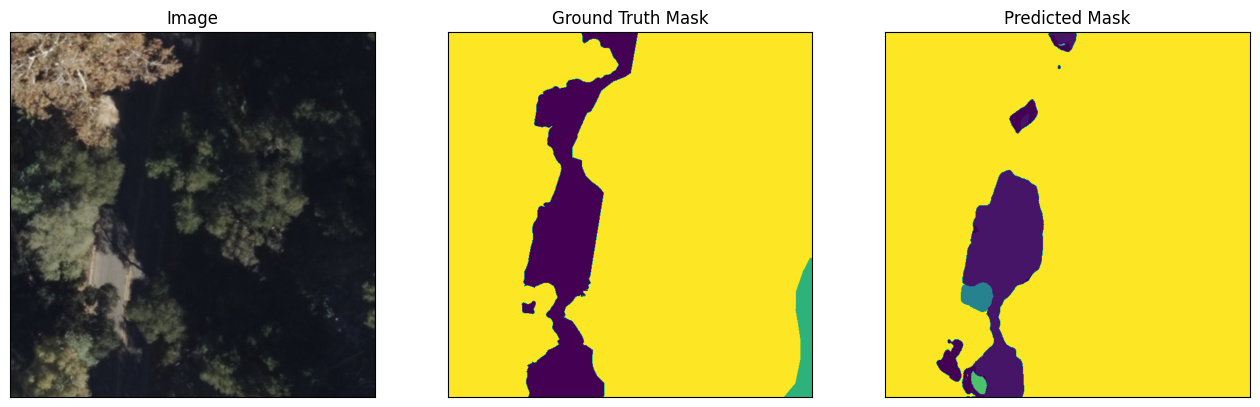

[0. 1.]
(640, 640, 3)
(640, 640)
(640, 640)


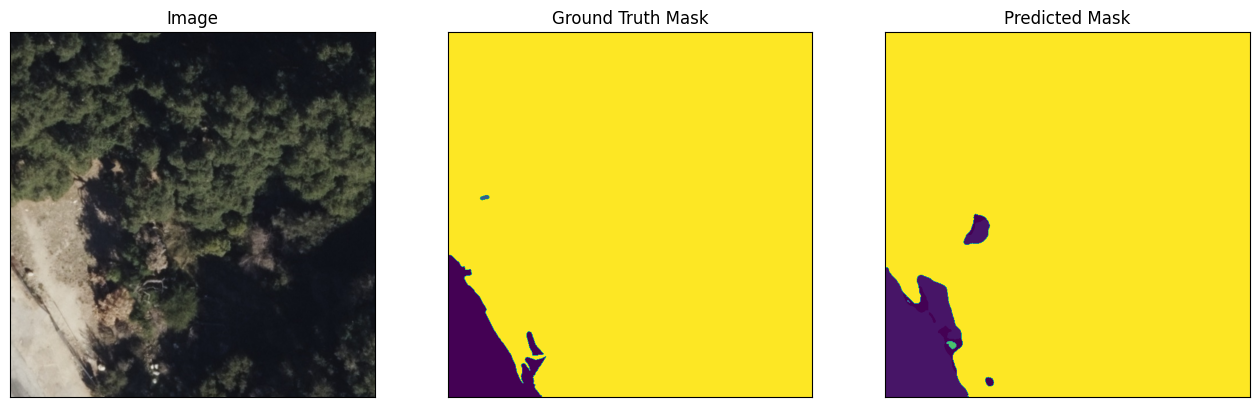

[0. 1.]
(640, 640, 3)
(640, 640)
(640, 640)


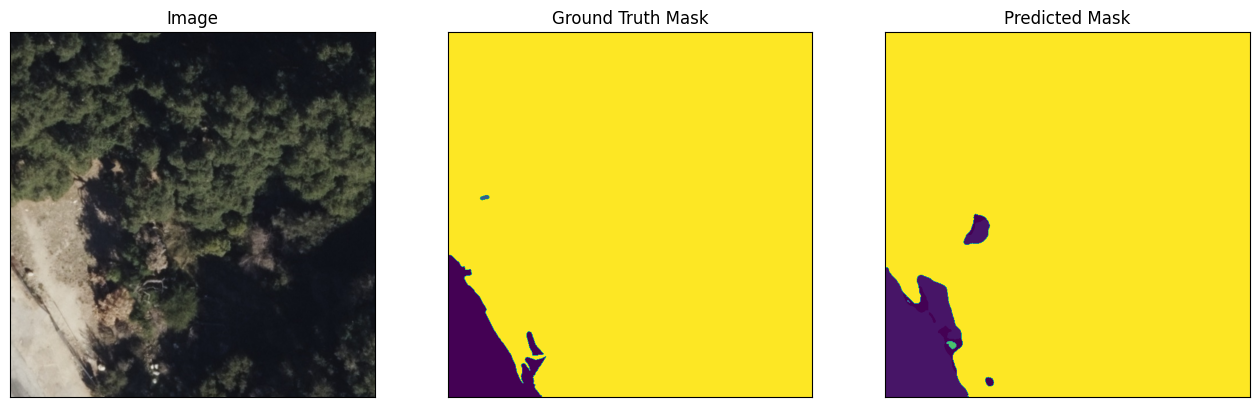

[0. 1.]
(640, 640, 3)
(640, 640)
(640, 640)


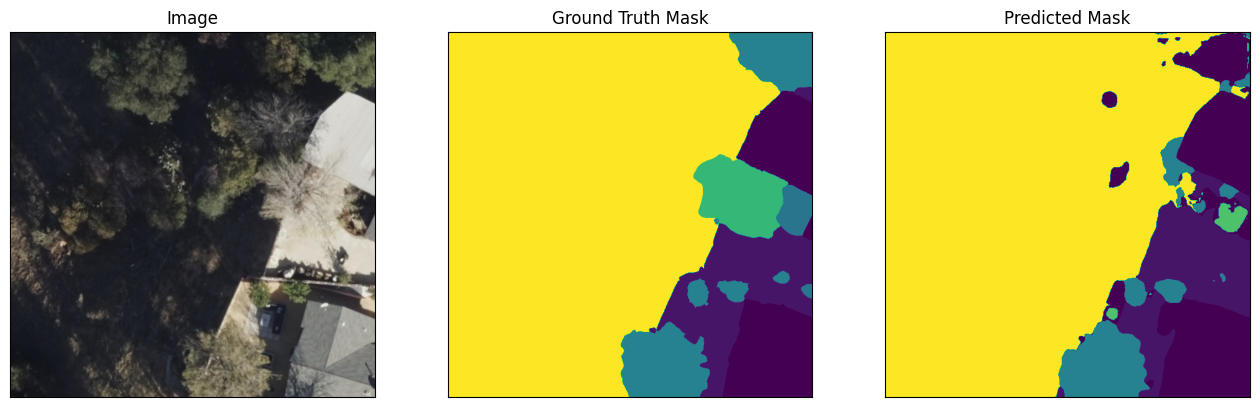

[0.]
(640, 640, 3)
(640, 640)
(640, 640)


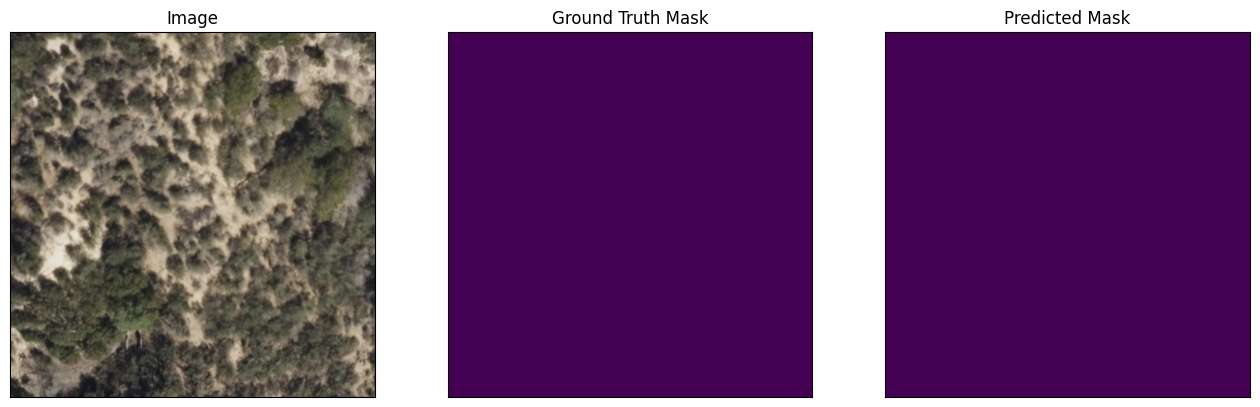

[0.]
(640, 640, 3)
(640, 640)
(640, 640)


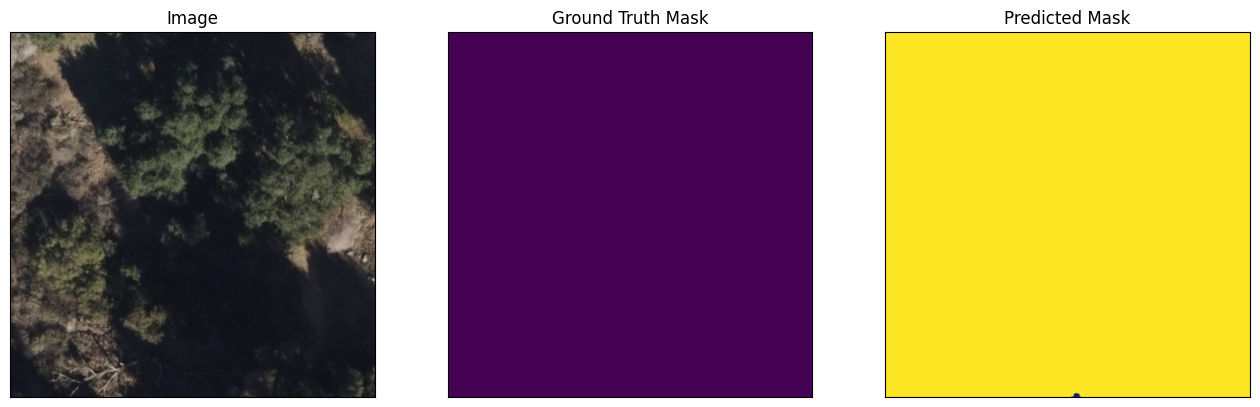

[0. 1.]
(640, 640, 3)
(640, 640)
(640, 640)


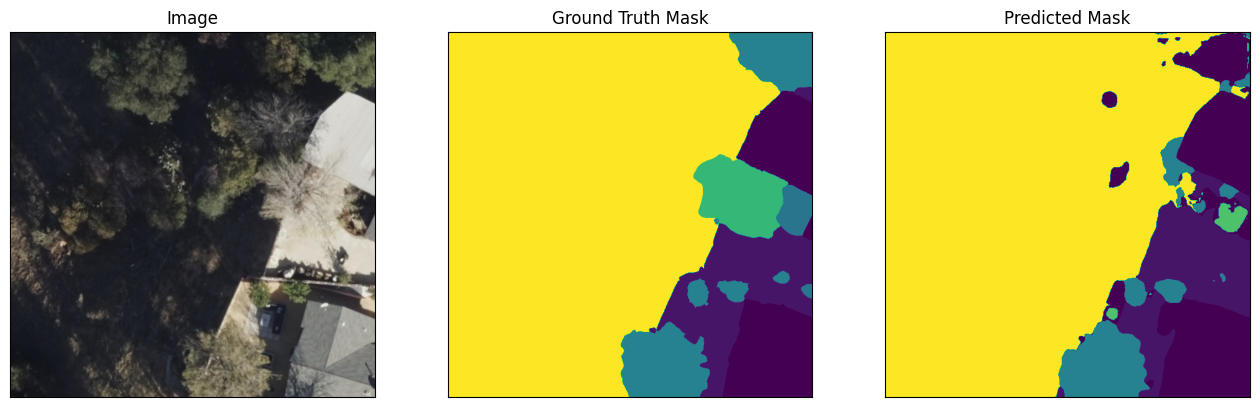

In [ ]:
    for i in range(len(test_dataset)):
        n = np.random.choice(len(test_dataset))

        image_vis = test_dataset_vis[n][0].astype('uint8')

        image, gt_mask = test_dataset[n]

        gt_mask = gt_mask.squeeze()
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        pr_mask = model.predict(x_tensor)
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        classification = np.argmax(pr_mask, axis=0)
        truth_raster = np.argmax(gt_mask, axis=0)

        # output_path = f"D:/code/pytorch_train/output/predicts/{i}.tif"
        # output_raster = rasterio.open(output_path,
        #                               'w',
        #                               driver='GTiff',
        #                               height=classification.shape[0], width=classification.shape[1],
        #                               count=1, dtype=str(rasterio.uint8),
        #                               crs='EPSG:5070',
        #                               transform=out_transform)
        # output_raster.write(classification, 1)
        # output_raster.close()
        print(np.unique(gt_mask[1]))
        visualize(
            image=image_vis,
            ground_truth_mask=truth_raster,
            predicted_mask=classification
        )
